In [1]:
!pip install lightning-bolts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 17.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-ma

In [2]:
!pip install pytorch-lightning

In [3]:
!pip install torch torchvision torchaudio

In [4]:
!pip install torchmetrics

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!gdown --id 1NjyNAfyqPlGZ6_6aoUtMuLKpvJUCUZiA -O /content/shared_utilities.py

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1NjyNAfyqPlGZ6_6aoUtMuLKpvJUCUZiA
From (redirected): https://drive.google.com/uc?id=1NjyNAfyqPlGZ6_6aoUtMuLKpvJUCUZiA&confirm=t&uuid=cb742277-1beb-4b94-8f7b-0d59187ae56f
To: /content/shared_utilities.py
100% 6.71k/6.71k [00:00<00:00, 26.9MB/s]


In [7]:
import pytorch_lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np
import torchvision

from shared_utilities import LightningModel, Cifar10DataModule, plot_loss_and_acc

In [8]:
L.pytorch_lightning.seed_everything(123)

dm = Cifar10DataModule(batch_size=64, num_workers=4)
dm.prepare_data()
dm.setup()

INFO:lightning_fabric.utilities.seed:Global seed set to 123


100%|██████████| 170498071/170498071 [00:02<00:00, 69728135.55it/s]


Extracting ./cifar-10-python.tar.gz to ./


In [9]:
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torch.utils.data.dataset import random_split

class Cifar10DataModule(L.LightningDataModule):
    def __init__(self, data_path="./", batch_size=64, num_workers=0,
                 train_transform=None, test_transform=None):
        super().__init__()
        self.batch_size = batch_size
        self.data_path = data_path
        self.num_workers = num_workers
        self.train_transform = train_transform
        self.test_transform = test_transform

    def prepare_data(self):
        datasets.CIFAR10(root=self.data_path, download=True)
        return

    def setup(self, stage=None):
        train = datasets.CIFAR10(
            root=self.data_path,
            train=True,
            transform=self.train_transform,
            download=False,
        )

        self.test = datasets.CIFAR10(
            root=self.data_path,
            train=False,
            transform=self.test_transform,
            download=False,
        )

        self.train, self.valid = random_split(train, lengths=[45000, 5000])

    def train_dataloader(self):
        train_loader = DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            drop_last=True,
            shuffle=True,
            num_workers=self.num_workers,
        )
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(
            dataset=self.valid,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(
            dataset=self.test,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )
        return test_loader

In [10]:
from torchvision import transforms

selfsupervised_transforms = transforms.Compose(
        [transforms.RandomResizedCrop(size=128),
         transforms.RandomHorizontalFlip(),
         transforms.RandomApply([transforms.ColorJitter(0.8 , 0.8, 0.8, 0.2)], p=0.8),
         transforms.RandomGrayscale(p=0.2),
         transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
         transforms.ToTensor()]
)


class AugmentedImages:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x):
        return [self.transforms(x), self.transforms(x)]

In [11]:
L.pytorch_lightning.seed_everything(123)

dm = Cifar10DataModule(batch_size=64, num_workers=4,
                       train_transform=AugmentedImages(selfsupervised_transforms),
                       test_transform=AugmentedImages(selfsupervised_transforms))
dm.prepare_data()
dm.setup()

INFO:lightning_fabric.utilities.seed:Global seed set to 123


Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


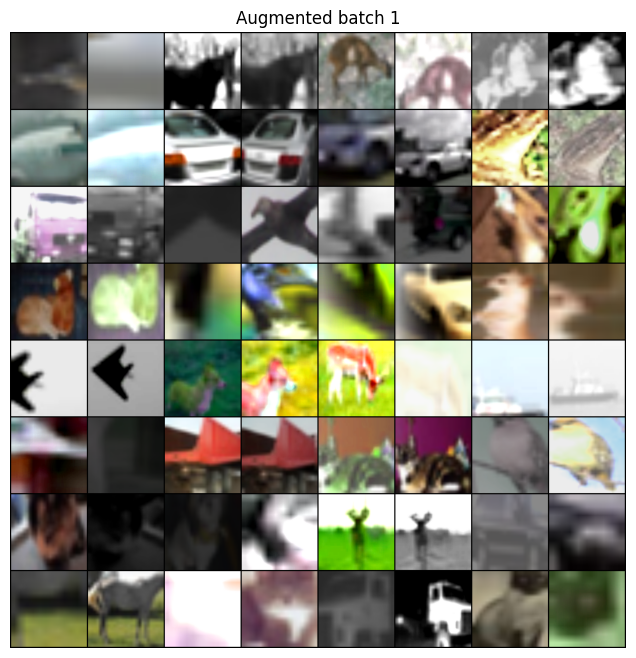

In [12]:
for images, labels in dm.train_dataloader():
    break

paired_images = []
for i in range(32):
    paired_images.append(images[0][i])
    paired_images.append(images[1][i])

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Augmented batch 1")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    paired_images[:64],
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

**Use 2 fully connected layers**

In [13]:
pytorch_model = torch.hub.load('pytorch/vision', 'resnet18', weights = None)

pytorch_model.fc = nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 256)
)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip


In [14]:
def info_nce_loss(feats, temperature, mode="train"):

    # Calculate cosine similarity
    cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)

    # Mask out cosine similarity to itself
    self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
    cos_sim.masked_fill_(self_mask, -9e15)

    # Find positive example -> batch_size//2 away from the original example
    pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)

    # InfoNCE loss
    cos_sim = cos_sim / temperature
    nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
    nll = nll.mean()

    comb_sim = torch.cat(
        [cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)],  # First position positive example
        dim=-1,
    )
    sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

    return nll, sim_argsort

**Update lightning model**

In [15]:
class LightningModelSimCLR(L.LightningModule):
    def __init__(self, model, learning_rate, temperature):
        super().__init__()

        self.learning_rate = learning_rate
        self.temperature = temperature
        self.model = model

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):

        ### NEW ###
        images, true_labels = batch
        images = torch.cat(images, dim=0)
        transformed_feats = self(images)

        loss, sim_argsort = info_nce_loss(transformed_feats, mode="train", temperature=self.temperature)
        self.log("train_loss", loss)
        self.log("train_acc", (sim_argsort < 5).float().mean())

        return loss

    def validation_step(self, batch, batch_idx):

        ### NEW ###
        images, true_labels = batch
        images = torch.cat(images, dim=0)
        transformed_feats = self(images)

        loss, sim_argsort = info_nce_loss(transformed_feats, mode="val", temperature=self.temperature)
        self.log("val_loss", loss)
        self.log("val_acc", (sim_argsort == 0).float().mean())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [16]:
L.seed_everything(123)

dm = Cifar10DataModule(batch_size=256, num_workers=4,
                       train_transform=AugmentedImages(selfsupervised_transforms),
                       test_transform=AugmentedImages(selfsupervised_transforms))

lightning_model = LightningModelSimCLR(model=pytorch_model, temperature=0.07, learning_rate=0.0005)

trainer = L.Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

INFO:lightning_fabric.utilities.seed:Global seed set to 123
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(model=lightning_model, datamodule=dm)

Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 11.6 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params
46.282    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


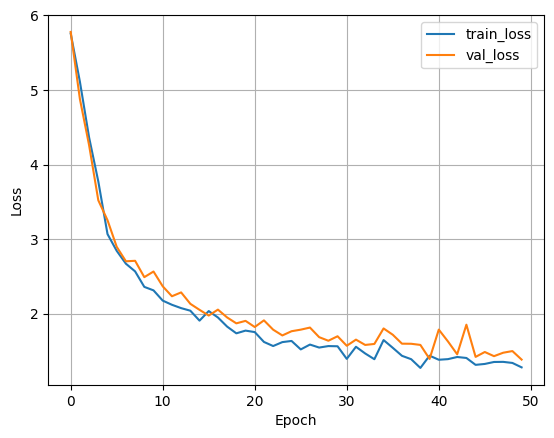

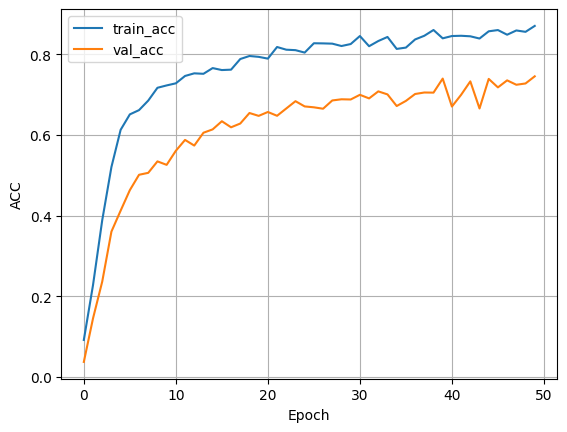

In [18]:
import pandas as pd

def plot_loss_and_acc(
    log_dir, loss_ylim=(0.0, 0.9), acc_ylim=(0.7, 1.0), save_loss=None, save_acc=None
):

    metrics = pd.read_csv(f"{log_dir}/metrics.csv")

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[["train_loss", "val_loss"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
    )

    #plt.ylim(loss_ylim)
    if save_loss is not None:
        plt.savefig(save_loss)

    df_metrics[["train_acc", "val_acc"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
    )

    #plt.ylim(acc_ylim)
    if save_acc is not None:
        plt.savefig(save_acc)


plot_loss_and_acc(trainer.logger.log_dir)

In [19]:
torch.save(pytorch_model.state_dict(), "simclr-resnet18.pt")